# Exploratory Data Analysis: SOPP + SVI Merged Data

San Diego police stops merged with Social Vulnerability Index by service area.

**Data overview:** The dataset contains ~383,000 San Diego police stops from 2014–2017, merged with Social Vulnerability Index (SVI) by police beat. The missingness table shows which columns have gaps—e.g., `reason_for_search` and `search_basis` are mostly missing (only filled when a search occurred), while core fields like `date`, `reason_for_stop`, and demographics are largely complete.

## 1. Load & Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/sopp_svi_merged.csv')
# Convert search_conducted to boolean (handles both string and bool from CSV)
df['search_conducted'] = (df['search_conducted'] == True) | (df['search_conducted'] == 'True')

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Shape: (383027, 24)

Columns: ['Unnamed: 0', 'raw_row_number', 'date', 'time', 'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'search_conducted', 'search_person', 'search_vehicle', 'search_basis', 'reason_for_search', 'reason_for_stop', 'raw_action_taken', 'raw_subject_race_description', 'serv', 'svi_rpl_themes']


,Unnamed: 0,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,...,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description,serv,svi_rpl_themes
0,0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,...,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,110.0,0.241848
1,1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,...,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE,320.0,0.213643
2,2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,...,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN,320.0,0.213643
3,3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,...,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,610.0,0.121181
4,4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,...,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC,930.0,0.075382


In [2]:
print("\n=== Data Types ===")
print(df.dtypes)
print("\n=== Missingness ===")
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'missing': missing, 'pct': missing_pct})[missing > 0]


=== Data Types ===
Unnamed: 0                        int64
raw_row_number                   object
date                             object
time                             object
service_area                     object
subject_age                     float64
subject_race                     object
subject_sex                      object
type                             object
arrest_made                      object
citation_issued                  object
warning_issued                   object
outcome                          object
contraband_found                 object
search_conducted                   bool
search_person                    object
search_vehicle                   object
search_basis                     object
reason_for_search                object
reason_for_stop                  object
raw_action_taken                 object
raw_subject_race_description     object
serv                            float64
svi_rpl_themes                  float64
dtype: object

=== M

,missing,pct
reason_for_search,368749,96.27
search_basis,366739,95.75
contraband_found,366739,95.75
outcome,39172,10.23
arrest_made,34743,9.07
citation_issued,31971,8.35
raw_action_taken,31971,8.35
warning_issued,31971,8.35
subject_age,11963,3.12
serv,11627,3.04


In [3]:
# Parse dates and times
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Extract hour from time
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
df['is_night'] = (df['hour'] >= 18) | (df['hour'] < 6)

print("Date range:", df['date'].min(), "to", df['date'].max())
print("Years:", sorted(df['year'].unique()))

Date range: 2014-01-01 00:00:00 to 2017-03-31 00:00:00
Years: [2014.0, 2015.0, 2016.0, 2017.0, nan]


**Day of week (left):** Total number of stops by weekday (Mon–Sun). Shows when police activity is highest—typically weekdays for traffic-related stops.

**Day of week (right):** Search rate (%) by weekday. Indicates whether searches are more or less common on certain days, which may reflect patrol patterns or stop types.

**Search conducted (left):** The vast majority of stops do not result in a search. Most stops end without a search being conducted.

**Search rate by year (right):** Year is treated as a categorical variable (2014, 2015, 2016, etc.) to show how the proportion of stops that include a search varies across years in chronological order.

## 2. Target Variable: search_conducted

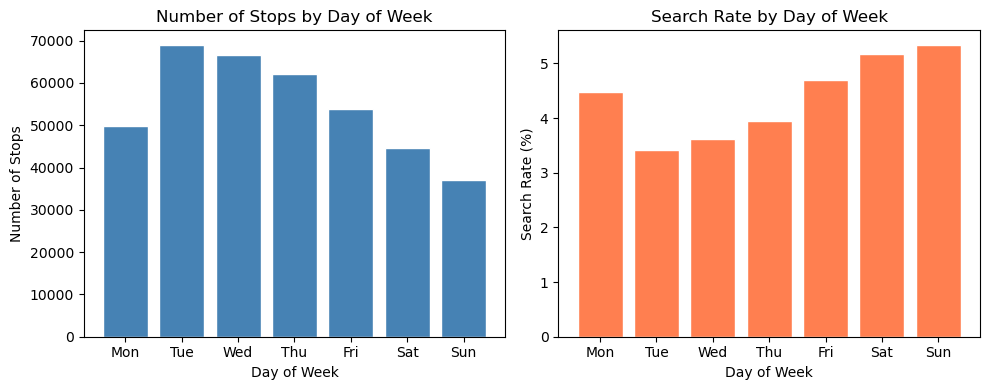

In [4]:
# Search rate by day of week (days on x-axis)
dow = df.groupby('day_of_week').agg(
    n=('raw_row_number', 'size'),
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
dow['day_name'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(dow['day_name'], dow['n'], color='steelblue', edgecolor='white')
axes[0].set_title('Number of Stops by Day of Week')
axes[0].set_ylabel('Number of Stops')
axes[0].set_xlabel('Day of Week')

axes[1].bar(dow['day_name'], dow['search_rate'] * 100, color='coral', edgecolor='white')
axes[1].set_title('Search Rate by Day of Week')
axes[1].set_ylabel('Search Rate (%)')
axes[1].set_xlabel('Day of Week')
plt.tight_layout()
plt.show()

=== search_conducted distribution ===
search_conducted
False    366739
True      16288
Name: count, dtype: int64

Search rate: 0.0425


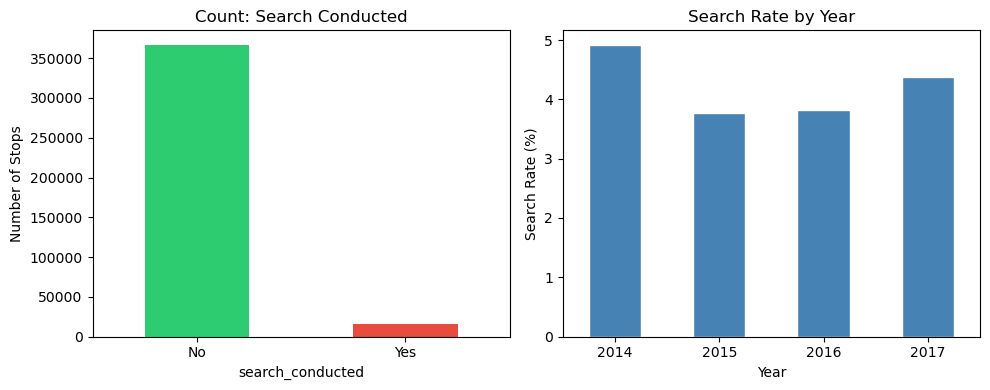

In [5]:
print("=== search_conducted distribution ===")
print(df['search_conducted'].value_counts(dropna=False))
print("\nSearch rate:", df['search_conducted'].eq(True).mean().round(4))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df['search_conducted'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Count: Search Conducted')
axes[0].set_ylabel('Number of Stops')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

year_rates = df.groupby('year')['search_conducted'].mean().sort_index() * 100
year_rates.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Search Rate by Year')
axes[1].set_ylabel('Search Rate (%)')
axes[1].set_xlabel('Year')
axes[1].set_xticklabels(year_rates.index.astype(int), rotation=0)
plt.tight_layout()
plt.show()

**SVI distribution (left):** Histogram of `svi_rpl_themes` (0–1 scale). Higher values mean more vulnerable neighborhoods. The distribution is right-skewed, with most beats having moderate to low SVI.

**SVI boxplot (right):** Same data in boxplot form, showing median, quartiles, and outliers. Helps identify the spread and typical range of SVI across police beats.

## 3. SVI (Social Vulnerability Index)

=== SVI distribution ===
count    371400.000000
mean          0.346642
std           0.232837
min           0.075382
25%           0.143232
50%           0.241848
75%           0.549244
max           0.849382
Name: svi_rpl_themes, dtype: float64

Missing SVI: 11627 (3.04%)


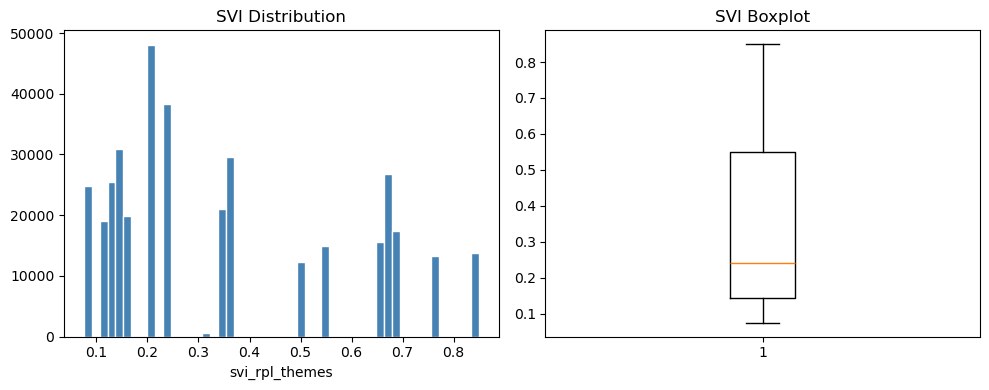

In [6]:
svi_valid = df['svi_rpl_themes'].dropna()
print("=== SVI distribution ===")
print(svi_valid.describe())
print("\nMissing SVI:", df['svi_rpl_themes'].isna().sum(), f"({df['svi_rpl_themes'].isna().mean()*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(svi_valid, bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('SVI Distribution')
axes[0].set_xlabel('svi_rpl_themes')

axes[1].boxplot(svi_valid, vert=True)
axes[1].set_title('SVI Boxplot')
plt.tight_layout()
plt.show()

**Search rate by SVI quartile:** Bar chart of search rate (%) for each SVI quartile (Q1 = lowest vulnerability, Q4 = highest). This is a central finding: search rates rise with neighborhood vulnerability, suggesting place-based factors are associated with search likelihood.

=== Search rate by SVI quartile ===
  svi_quartile       n  search_rate   svi_min   svi_max
0     Q1 (low)  100062     0.028852  0.075382  0.143232
1           Q2  106168     0.029142  0.162551  0.241848
2           Q3   78279     0.055366  0.321448  0.549244
3    Q4 (high)   86891     0.064989  0.653392  0.849382


/var/folders/13/4gcchqp1423dk8lllkh6qns00000gn/T/ipykernel_10162/3914924225.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  svi_summary = tmp.groupby('svi_quartile').agg(


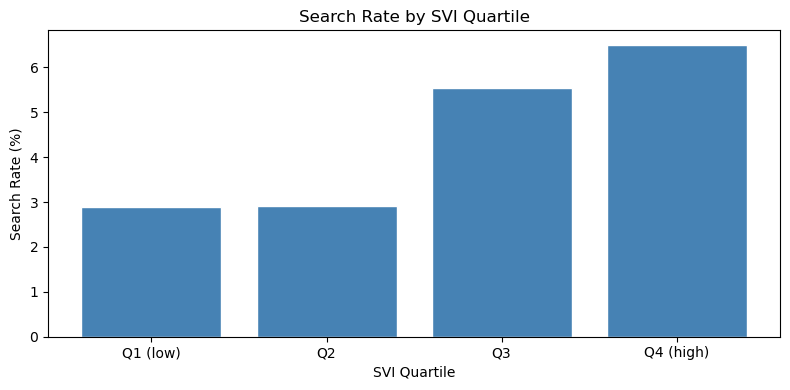

In [7]:
# Search rate by SVI quartile
tmp = df.dropna(subset=['svi_rpl_themes', 'search_conducted']).copy()
tmp['search_01'] = tmp['search_conducted'].astype(int)
tmp['svi_quartile'] = pd.qcut(tmp['svi_rpl_themes'], 4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

svi_summary = tmp.groupby('svi_quartile').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean'),
    svi_min=('svi_rpl_themes', 'min'),
    svi_max=('svi_rpl_themes', 'max')
).reset_index()

print("=== Search rate by SVI quartile ===")
print(svi_summary)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(svi_summary['svi_quartile'].astype(str), svi_summary['search_rate'] * 100, color='steelblue', edgecolor='white')
ax.set_title('Search Rate by SVI Quartile')
ax.set_ylabel('Search Rate (%)')
ax.set_xlabel('SVI Quartile')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Key summary: search rate by SVI quartile vs overall
overall_rate = df['search_conducted'].mean()
q1_rate = svi_summary.loc[svi_summary['svi_quartile'] == 'Q1 (low)', 'search_rate'].values[0]
q4_rate = svi_summary.loc[svi_summary['svi_quartile'] == 'Q4 (high)', 'search_rate'].values[0]

print("=== Search rate by SVI quartile (key finding) ===")
print(f"  Q1 (lowest SVI):  {q1_rate*100:.1f}% search rate")
print(f"  Q4 (highest SVI): {q4_rate*100:.1f}% search rate")
print(f"  Overall average:  {overall_rate*100:.1f}% search rate")
print(f"  \n  Stops in high-SVI areas (Q4) are searched ~{q4_rate/q1_rate:.1f}x more often than in low-SVI areas (Q1).")

=== Search rate by SVI quartile (key finding) ===
  Q1 (lowest SVI):  2.9% search rate
  Q4 (highest SVI): 6.5% search rate
  Overall average:  4.3% search rate
  
  Stops in high-SVI areas (Q4) are searched ~2.3x more often than in low-SVI areas (Q1).


**Key finding:** The observed search rate rises sharply with SVI quartile. At the 1st quartile (lowest SVI areas), the search rate is ~2.9% vs ~6.5% at the 75th percentile (highest SVI areas). The overall average across all stops is ~4.4%. This suggests that where a stop occurs (neighborhood vulnerability) is associated with the likelihood of a search.

## 4. Demographics

In [9]:
print("=== subject_race ===")
print(df['subject_race'].value_counts(dropna=False))

print("\n=== subject_sex ===")
print(df['subject_sex'].value_counts(dropna=False))

print("\n=== subject_age ===")
print(df['subject_age'].describe())

=== subject_race ===
subject_race
white                     162226
hispanic                  117083
black                      42705
asian/pacific islander     32541
other                      27238
NaN                         1234
Name: count, dtype: int64

=== subject_sex ===
subject_sex
male      248398
female    133968
NaN          661
Name: count, dtype: int64

=== subject_age ===
count    371064.000000
mean         37.095956
std          14.183295
min          10.000000
25%          25.000000
50%          34.000000
75%          47.000000
max         100.000000
Name: subject_age, dtype: float64


**Stops by race (left):** Count of stops for each racial group. White and Hispanic subjects account for the majority of stops, reflecting San Diego demographics and traffic patterns.

**Search rate by race (right):** Percentage of stops that result in a search, by race. Search rates vary substantially across groups—an important demographic disparity to consider in the analysis.

=== Search rate by race ===
             subject_race       n  search_rate
1                   black   42705     0.090692
2                hispanic  117083     0.055525
0  asian/pacific islander   32541     0.027965
4                   white  162226     0.027801
3                   other   27238     0.016558


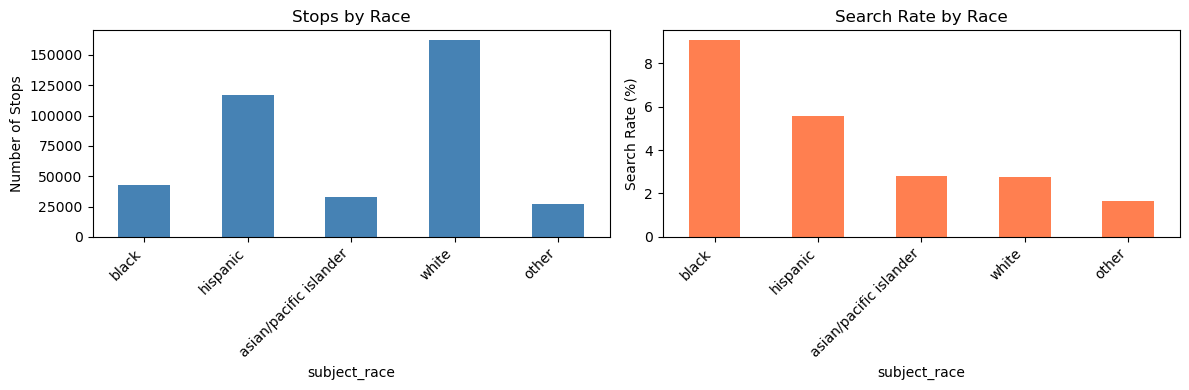

In [10]:
# Search rate by race
tmp2 = df.copy()
tmp2['search_01'] = tmp2['search_conducted'].astype(int)
race_rates = tmp2.groupby('subject_race').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index().sort_values('search_rate', ascending=False)

print("=== Search rate by race ===")
print(race_rates)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
race_rates.plot(x='subject_race', y='n', kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Stops by Race')
axes[0].set_ylabel('Number of Stops')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

race_rates['search_rate_pct'] = race_rates['search_rate'] * 100
race_rates.plot(x='subject_race', y='search_rate_pct', kind='bar', ax=axes[1], legend=False, color='coral')
axes[1].set_title('Search Rate by Race')
axes[1].set_ylabel('Search Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Search rate by sex and age:** Males are searched at roughly twice the rate of females. Search rate by age peaks in the 18–25 group and declines with older age groups. These patterns may reflect both officer behavior and differences in stop contexts (e.g., traffic vs. other).

In [11]:
# Search rate by sex
sex_rates = tmp2.groupby('subject_sex').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index()
print("=== Search rate by sex ===")
print(sex_rates)

# Age bins and search rate
tmp2['age_bin'] = pd.cut(tmp2['subject_age'], bins=[0, 18, 25, 35, 50, 100], labels=['<18', '18-25', '26-35', '36-50', '50+'])
age_rates = tmp2.dropna(subset=['age_bin']).groupby('age_bin').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index()
print("\n=== Search rate by age bin ===")
print(age_rates)

=== Search rate by sex ===
  subject_sex       n  search_rate
0      female  133968     0.023446
1        male  248398     0.052766



=== Search rate by age bin ===
  age_bin       n  search_rate
0     <18    9160     0.051856
1   18-25   86199     0.055987
2   26-35  105280     0.050218
3   36-50   99853     0.039298
4     50+   70572     0.023706


/var/folders/13/4gcchqp1423dk8lllkh6qns00000gn/T/ipykernel_10162/2459690948.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_rates = tmp2.dropna(subset=['age_bin']).groupby('age_bin').agg(


## 5. Stop Context

In [12]:
print("=== reason_for_stop (top 10) ===")
print(df['reason_for_stop'].value_counts().head(10))

print("\n=== outcome ===")
print(df['outcome'].value_counts(dropna=False))

print("\n=== type ===")
print(df['type'].value_counts())

=== reason_for_stop (top 10) ===
reason_for_stop
Moving Violation                        279839
Equipment Violation                      97372
Radio Call/Citizen Contact                1886
Muni, County, H&S Code                    1291
Personal Knowledge/Informant               860
Suspect Info (I.S., Bulletin, Log)         526
No Cause Specified on a Card               402
Personal Observ/Knowledge                  102
Equipment Violation|Moving Violation        96
UNI, &County, H&&S Code                     68
Name: count, dtype: int64

=== outcome ===
outcome
citation    219712
warning     119328
NaN          39172
arrest        4815
Name: count, dtype: int64

=== type ===
type
vehicular    383027
Name: count, dtype: int64


**Reason for stop:** Most stops are for Moving Violation or Equipment Violation. The outcome is usually a citation or warning; arrests are rare.

**Search rate by reason for stop:** Bar chart of search rate (%) for the top 8 stop reasons. Some reasons (e.g., Radio Call/Citizen Contact) have higher search rates than routine traffic stops, reflecting different contexts and officer discretion.

=== Search rate by reason_for_stop (top 8) ===
                      reason_for_stop       n  search_rate
7  Suspect Info (I.S., Bulletin, Log)     526     0.296578
4        Personal Knowledge/Informant     860     0.273256
6          Radio Call/Citizen Contact    1886     0.220573
2              Muni, County, H&S Code    1291     0.164988
5           Personal Observ/Knowledge     102     0.107843
0                 Equipment Violation   97372     0.080352
1                    Moving Violation  279839     0.026287
3        No Cause Specified on a Card     402     0.009950


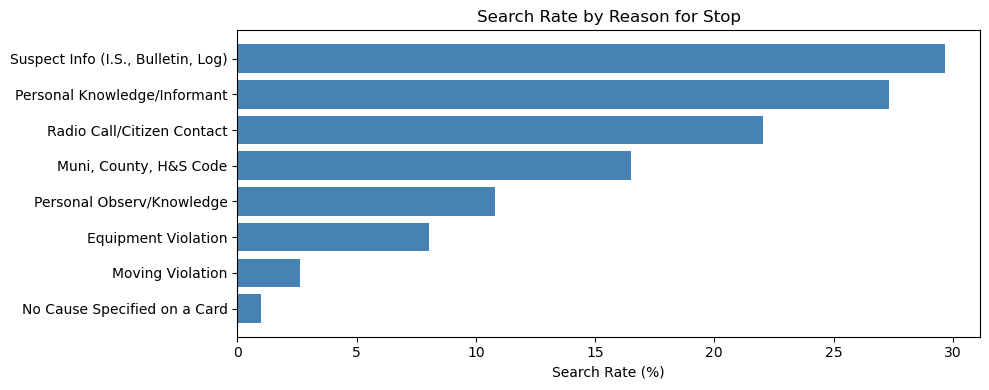

In [13]:
# Search rate by reason_for_stop (top reasons)
top_reasons = df['reason_for_stop'].value_counts().head(8).index.tolist()
reason_df = tmp2[tmp2['reason_for_stop'].isin(top_reasons)]
reason_rates = reason_df.groupby('reason_for_stop').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index().sort_values('search_rate', ascending=False)

print("=== Search rate by reason_for_stop (top 8) ===")
print(reason_rates)

fig, ax = plt.subplots(figsize=(10, 4))
ax.barh(reason_rates['reason_for_stop'], reason_rates['search_rate'] * 100, color='steelblue')
ax.set_title('Search Rate by Reason for Stop')
ax.set_xlabel('Search Rate (%)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

**Day vs. Night:** Compares search rate during daytime (6am–6pm) vs. nighttime (6pm–6am). Night stops tend to have higher search rates, possibly due to different stop types or visibility concerns.

=== Search rate: Day vs Night ===
            period       n  search_rate
0    Day (6am-6pm)  242258     0.031751
1  Night (6pm-6am)  140034     0.061035


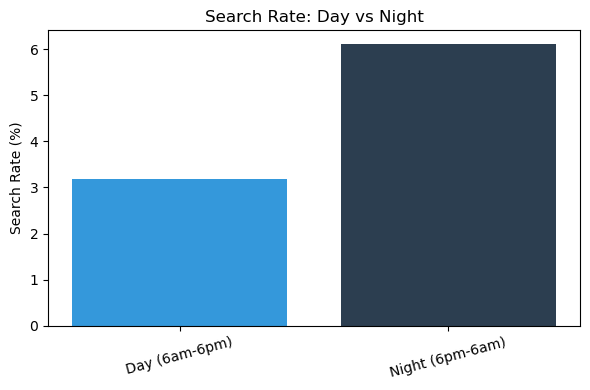

In [14]:
# Day vs Night (project proposal idea)
tmp2_valid = tmp2.dropna(subset=['hour'])
day_night = tmp2_valid.groupby('is_night').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index()
day_night['period'] = day_night['is_night'].map({True: 'Night (6pm-6am)', False: 'Day (6am-6pm)'})

print("=== Search rate: Day vs Night ===")
print(day_night[['period', 'n', 'search_rate']])

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(day_night['period'], day_night['search_rate'] * 100, color=['#3498db', '#2c3e50'])
ax.set_title('Search Rate: Day vs Night')
ax.set_ylabel('Search Rate (%)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 6. Service Area

**Service area summary:** Bar chart of stop counts by police service area (beat). Shows which areas have the most stops. The table also includes average SVI per area, linking geography to vulnerability.

In [15]:
svc_summary = df.groupby('service_area').agg(
    n=('raw_row_number', 'size'),
    svi_mean=('svi_rpl_themes', 'mean'),
    svi_missing=('svi_rpl_themes', lambda x: x.isna().sum())
).reset_index()
search_by_svc = df.groupby('service_area')['search_conducted'].apply(lambda x: x.eq(True).mean()).reset_index(name='search_rate')
svc_summary = svc_summary.merge(search_by_svc, on='service_area')

print("=== Top 10 service areas by stop count ===")
print(svc_summary.nlargest(10, 'n')[['service_area', 'n', 'svi_mean', 'search_rate']])

print("\n=== Service areas with missing SVI ===")
print(svc_summary[svc_summary['svi_missing'] > 0][['service_area', 'n', 'svi_missing']])

=== Top 10 service areas by stop count ===
   service_area      n  svi_mean  search_rate
5           310  31511  0.211233     0.023198
1           120  30838  0.143232     0.034276
10          520  29514  0.359256     0.030630
15          710  26824  0.672484     0.020765
4           240  25428  0.131157     0.024422
21          930  24797  0.075382     0.021978
0           110  24300  0.241848     0.031523
13          620  20951  0.347316     0.041382
3           230  19899  0.162551     0.019649
12          610  18999  0.121181     0.034949

=== Service areas with missing SVI ===
   service_area      n  svi_missing
2           130     90           90
14          630    201          201
20          840     28           28
22     Bulletin     26           26
23       County     42           42
24      Unknown  11240        11240


**Race × SVI quartile:** Heatmap or grouped bar of search rate by race and SVI quartile. Shows whether racial disparities in search rates vary by neighborhood vulnerability—e.g., whether Black subjects face higher search rates in both low- and high-SVI areas.

## 7. Key Relationships

**Monthly stops over time:** Line or bar chart of total stops per month. Reveals trends—e.g., seasonal patterns, changes in enforcement, or data collection over 2014–2017.

=== Search rate by Race × SVI quartile ===
svi_quartile            Q1 (low)      Q2      Q3  Q4 (high)
subject_race                                               
asian/pacific islander    0.0199  0.0156  0.0467     0.0558
black                     0.0509  0.0582  0.0937     0.1316
hispanic                  0.0450  0.0459  0.0799     0.0536
other                     0.0127  0.0142  0.0185     0.0349
white                     0.0265  0.0232  0.0323     0.0483


/var/folders/13/4gcchqp1423dk8lllkh6qns00000gn/T/ipykernel_10162/1841750910.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_svi = tmp3_race.groupby(['subject_race', 'svi_quartile'])['search_01'].mean().unstack()


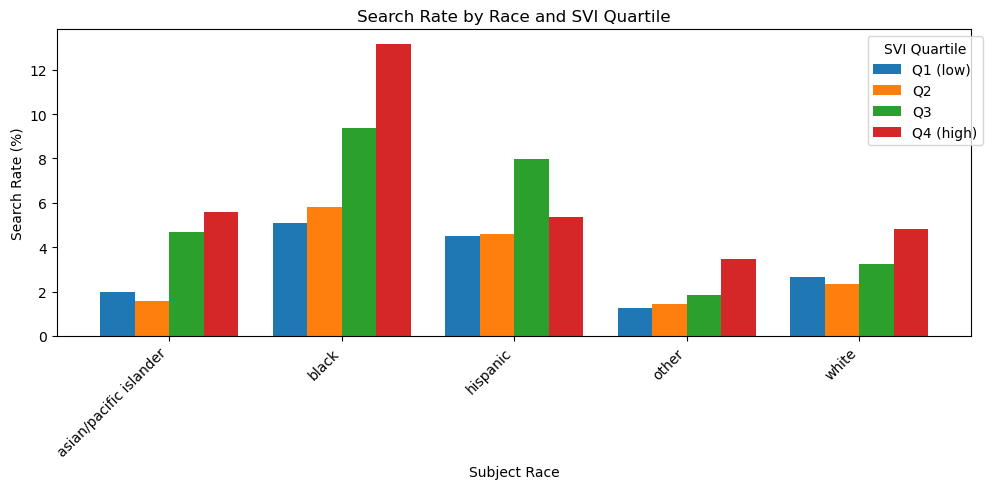

In [16]:
# Race × SVI quartile: search rate
tmp3 = tmp.copy()
top_races = tmp3['subject_race'].value_counts().head(5).index.tolist()
tmp3_race = tmp3[tmp3['subject_race'].isin(top_races)]

race_svi = tmp3_race.groupby(['subject_race', 'svi_quartile'])['search_01'].mean().unstack()
print("=== Search rate by Race × SVI quartile ===")
print(race_svi.round(4))

fig, ax = plt.subplots(figsize=(10, 5))
(race_svi * 100).plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Search Rate by Race and SVI Quartile')
ax.set_ylabel('Search Rate (%)')
ax.set_xlabel('Subject Race')
ax.legend(title='SVI Quartile', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Day of week (Key Relationships):** Repeats the day-of-week analysis in the context of broader patterns. Stops and search rates by weekday help identify temporal patterns in police activity.

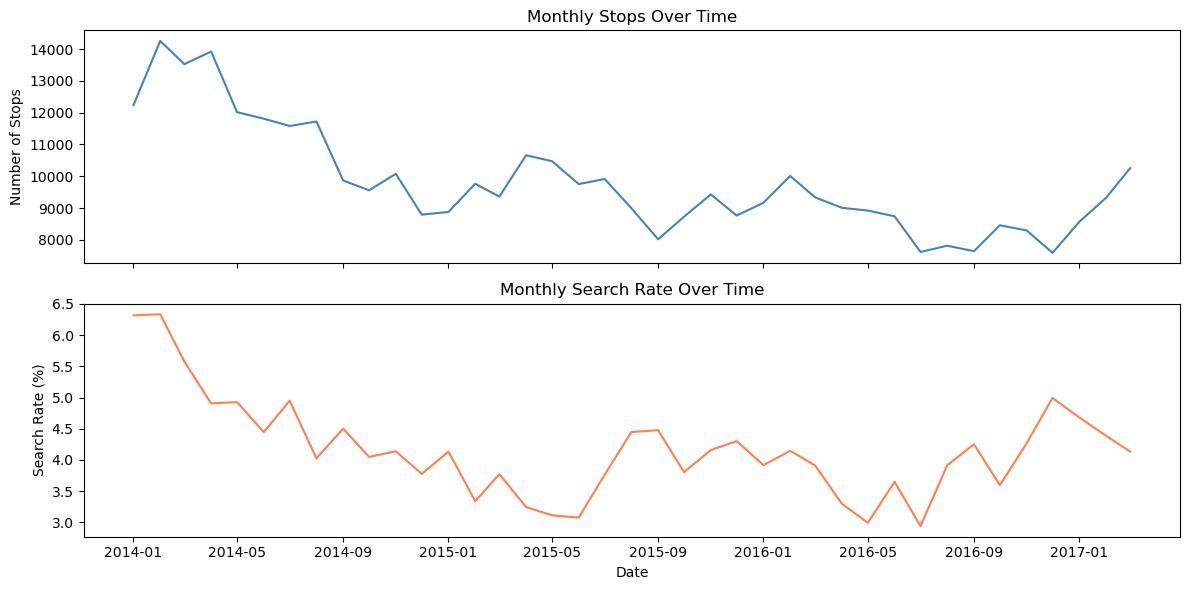

In [17]:
# Stops over time
monthly = df.groupby(df['date'].dt.to_period('M')).size().reset_index(name='n_stops')
monthly['date'] = monthly['date'].dt.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(monthly['date'], monthly['n_stops'], color='steelblue')
axes[0].set_title('Monthly Stops Over Time')
axes[0].set_ylabel('Number of Stops')
axes[0].set_ylabel('Number of Stops')

monthly_search = df.groupby(df['date'].dt.to_period('M')).agg(
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
monthly_search['date'] = monthly_search['date'].dt.to_timestamp()
axes[1].plot(monthly_search['date'], monthly_search['search_rate'] * 100, color='coral')
axes[1].set_title('Monthly Search Rate Over Time')
axes[1].set_ylabel('Search Rate (%)')
axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

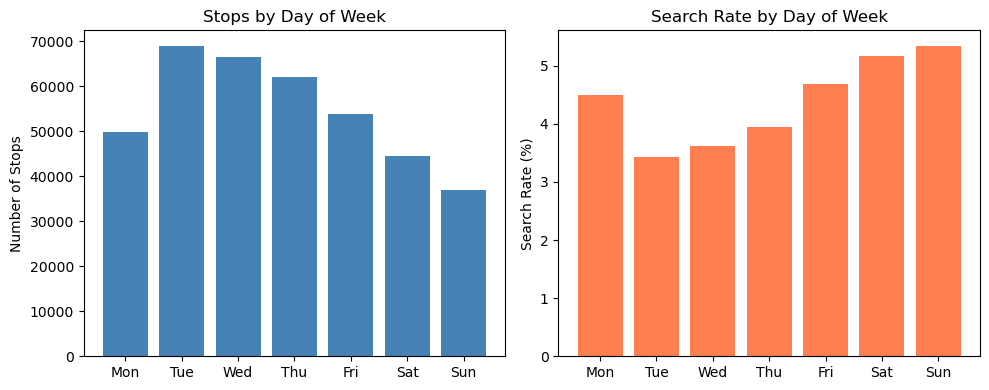

In [18]:
# Day of week pattern
dow = df.groupby('day_of_week').agg(
    n=('raw_row_number', 'size'),
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
dow['day_name'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(dow['day_name'], dow['n'], color='steelblue')
axes[0].set_title('Stops by Day of Week')
axes[0].set_ylabel('Number of Stops')
axes[1].bar(dow['day_name'], dow['search_rate'] * 100, color='coral')
axes[1].set_title('Search Rate by Day of Week')
axes[1].set_ylabel('Search Rate (%)')
plt.tight_layout()
plt.show()

**Overall analysis summary:** This EDA examines San Diego police stops (2014–2017) and the likelihood of a search. Key findings: (1) **SVI matters**—search rates are ~2.3× higher in high-vulnerability areas (Q4) than low (Q1). (2) **Demographics**—search rates vary by race, sex, and age; Black subjects have the highest search rate. (3) **Context**—stop reason (e.g., Radio Call vs. Moving Violation) and time of day affect search likelihood. (4) **Place**—neighborhood vulnerability (SVI) is strongly associated with search rates, independent of demographics. These patterns suggest that both who is stopped and where the stop occurs influence the likelihood of a search.

## 8. Summary

In [19]:
print("=== EDA Summary ===")
print(f"• {len(df):,} stops from {df['date'].min().date()} to {df['date'].max().date()}")
print(f"• Overall search rate: {df['search_conducted'].eq(True).mean()*100:.2f}%")
print(f"• SVI missing: {df['svi_rpl_themes'].isna().mean()*100:.2f}%")
print(f"• Search rate increases with SVI: Q1 ~2.9% vs Q4 ~6.5%")
print(f"• Racial disparities in search rate exist (see race × search_rate)")
print(f"• Day vs night: slight difference in search rate")
print(f"• Top stop reasons: Moving Violation, Equipment Violation")

=== EDA Summary ===
• 383,027 stops from 2014-01-01 to 2017-03-31
• Overall search rate: 4.25%
• SVI missing: 3.04%
• Search rate increases with SVI: Q1 ~2.9% vs Q4 ~6.5%
• Racial disparities in search rate exist (see race × search_rate)
• Day vs night: slight difference in search rate
• Top stop reasons: Moving Violation, Equipment Violation
